In [1]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import ScalarFormatter
import statistics as stat

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH= 12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

FIXED_COLOR  = 'tbd'
STATIC_COLOR = 'tbd'
DYNAMIC_COLOR= 'tbd'

FIXED_MARKER='tbd'
STATIC_MARKER='tbd'
DYNAMIC_MARKER='tbd'

In [2]:
experiments = [
    'surrogate-all_params', ## Simple surrogate, all uq, 500,1000K, RI: 1,50(for 500K), 100,500(1000K)
    'ss-true-rs1_LAZYTRAIN', ## Running with best parameters (UQ 0.3, RI = 50) with lazy training, without reference data
]

##Running Proxima without reference data (true)
experiments_true = [
    'true-run_rs1',
    'true-run_rs2',
    'true-run_rs3',
    'true-run_rs4',
    'true-run_rs5',
    'true-run_rs6',
    'true-run_rs7',
    'true-run_rs8',
    'true-run_rs9',
    'true-run_rs10',
]

#Running FIXED(0.3,50)
experiment_ss = [
    'ss-true_rs1',
    'ss-true_rs2',
    'ss-true_rs3',
    'ss-true_rs4',
    'ss-true_rs5',
    'ss-true_rs6',
    'ss-true_rs7',
    'ss-true_rs8',
    'ss-true_rs9',
    'ss-true_rs10',
]

root_path = '../proxima_data'

## (1) Dynamic Tolerance + Alpha

In [3]:
run_name = 'dyn_ns_lazy111220'
alpha_run = 'alpha_dynlazyns'
control_name = run_name + '_T_change'

file = "/".join([root_path, run_name,'*'])
results_d = {}
files = glob.glob(file)
for f in files:
    control_fn = os.path.basename(f).split('_')
    temp_c = control_fn[6]
    results_d[temp_c] = pd.read_csv(f + '/tests_run_data.csv')
    temp_a = temp_c +'k.txt'
    control_fn.pop(1)
    control_fn.pop(1)
    control_fn[1] = 'UQ'
    control_fn = 'control_uq' + '_'.join(control_fn)
    control_data = open("/".join([root_path,control_name,control_fn + '.txt']))
    control_results = np.loadtxt(control_data)
    
    alpha_data = open("/".join([root_path,alpha_run,alpha_run+'_'+temp_a]))
    alpha_results = np.loadtxt(alpha_data, dtype='object')
    alpha_results = np.where(alpha_results == 'None', np.nan,alpha_results)
    alpha_results = alpha_results.astype(np.float)
                                     
    results_d[temp_c]['tolerance'] = control_results
    results_d[temp_c]['alpha'] = alpha_results


In [4]:
def graph_tol_alpha(variant, results, temp):
    TOLERANCE_COLOR = colors[0]
    ALPHA_COLOR = colors[1]
    TOLERANCE_LABEL = 'Tolerance'
    ALPHA_LABEL = 'Alpha'
    temp = str(temp) # temperature to plot
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))

    #plt.plot(results['500']['step'], results['500']['tolerance'], 'v', fillstyle='none', color=colors[0], markersize=5, label='Tolerance')
    p1, = plt.plot(results[temp]['step'], results[temp]['alpha'], 'o', fillstyle='none', color=ALPHA_COLOR, markersize=5, label=ALPHA_LABEL)

    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    h1, l1 = ax.get_legend_handles_labels()
    ax.set_ylabel('Alpha', fontsize=BIG, color=ALPHA_COLOR)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM, color=ALPHA_COLOR)
    ax.set_ylim(0, 0.013)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.yaxis.get_offset_text().set_color(ALPHA_COLOR)

    ax2 = ax.twinx()
    p2, = plt.plot(results[temp]['step'], results[temp]['tolerance'], 'v', fillstyle='none', color=TOLERANCE_COLOR, markersize=5, label=TOLERANCE_LABEL)
    ax2.set_ylabel('Tolerance', fontsize=BIG, color=TOLERANCE_COLOR)
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.set_ylim(bottom=0)
    ax2.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM, color=TOLERANCE_COLOR)
    ax2.yaxis.get_offset_text().set_fontsize(MEDIUM)

    ax.set_xlabel('Steps', fontsize=BIG)
    
    legend = plt.legend([p1, p2], [ALPHA_LABEL, TOLERANCE_LABEL], markerscale=2, fontsize=BIG) # loc='upper left')
    texts = legend.get_texts()
    plt.setp(texts[0], color=ALPHA_COLOR)
    plt.setp(texts[1], color=TOLERANCE_COLOR)
    
    plt.tight_layout()
    plt.savefig('Paper_figures/'+variant+'_tolerance_and_alpha_'+temp+'K.pdf')
    plt.show()

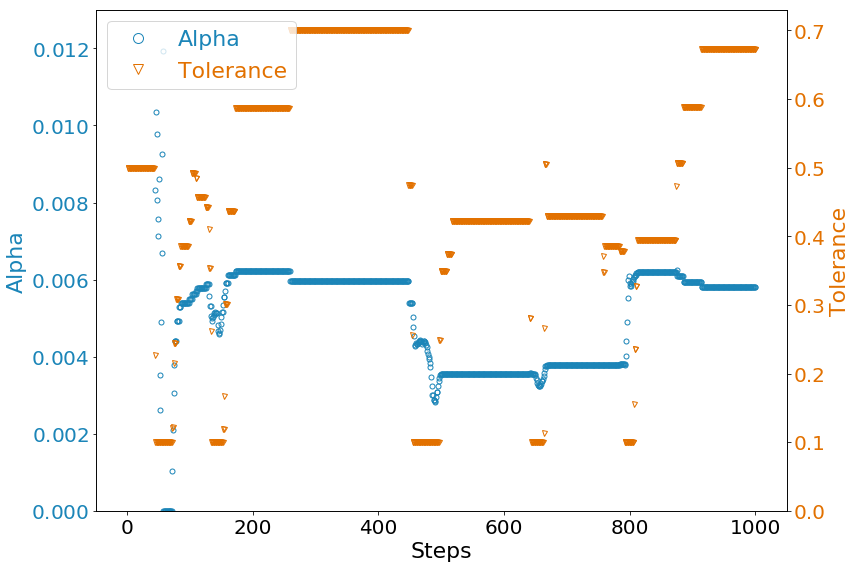

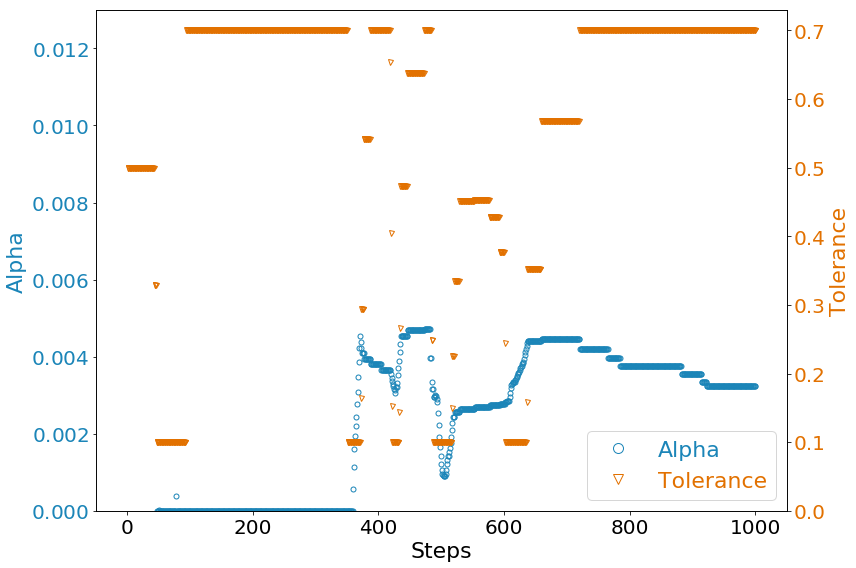

In [5]:
graph_tol_alpha('dynamic', results_d, 500)
graph_tol_alpha('dynamic', results_d, 800) ## results, temperature


## Loading HF and Experiment Results

In [6]:
#root_path_hf = '/home/yzamora/proxima/examples/molecule-sampling'
path_str = '/'.join([root_path,'runtime_s1_data.csv'])
hf_times = pd.read_csv(path_str)

results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## Plot Cases

In [77]:
def _plot_cases_adapted(cases): #df_a, df_b, df_c, df_d):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        
        good   = [(x,y,t,i) for (x,y,t,i) in zip(df[x], df[y], df['uq'], df['interval']) if x < XLINE and y < YLINE]
        hiTime = [(x,y) for (x,y) in zip(df[x], df[y]) if x >= XLINE]
        hiMAE  = [(x,y) for (x,y) in zip(df[x], df[y]) if x < XLINE and y >= YLINE]
        good_x, good_y, _, _ = zip(*good)
        hiTime_x, hiTime_y   = zip(*hiTime)
        hiMAE_x, hiMAE_y     = zip(*hiMAE)
        plt.scatter(x=good_x,   y=good_y,   color='g',       facecolors='none', marker='s', s=36)
        plt.scatter(x=hiMAE_x,  y=hiMAE_y,  color=colors[1], facecolors='none', marker='v', s=36)
        plt.scatter(x=hiTime_x, y=hiTime_y, color=colors[0], facecolors='none', marker='o', s=36)
        # Customized position code. But then the whole function is customized...
        """for x, y, t, i in good:
            if t==0.2:
                if i==50:
                    ax.annotate(f'{t}, {i}', (x-110, y-0.0005), color='green', fontsize=12)
                else:
                    ax.annotate(f'{t}, {i}', (x-95, y-0.0005), color='green', fontsize=12)
            else:
                ax.annotate(f'{t}, {i}', (x-50, y-0.0005), color='green', fontsize=12)"""

    ax.set_ylim([0.0, 0.009])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', useMathText=True, scilimits=(0,0))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    ax.axvline(x=XLINE, color=TIME_COLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAE_COLOR,  linewidth=1)
    
    plt.xlabel('Execution time',      fontsize=BIG)
    plt.ylabel('Mean absolute error', fontsize=BIG)
    plt.xticks(fontsize=BIG)
    plt.yticks(fontsize=BIG)
    ax.yaxis.get_offset_text().set_fontsize(BIG)
    
    #plt.text(560,   0.0072, 'Baseline time', rotation=90, color=colors[0], fontsize=BIG-1)
    plt.text(560,   0.0072, 'Baseline time', rotation=90, color=TIME_COLOR, fontsize=BIG)
    plt.text(13000, 0.0023, 'Target MAE',                 color=MAE_COLOR, fontsize=BIG)
    
    plt.text(50,    0.0008, 'N='+str(len(good_x)),     color='g',       fontsize=BIG)
    plt.text(230,   0.007,  'N='+str(len(hiMAE_x)),    color=colors[1], fontsize=BIG)    
    plt.text(10000, 0.0008, 'N='+str(len(hiTime_x)), color=colors[0], fontsize=BIG)
    
    plt.scatter([XLINE], [0], color='r', marker='o', s=36, clip_on=False)
    #plt.scatter([441.544], [0.001595],   color='r', marker='o', facecolors='none', linewidths=2, s=60)
    ax

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='s', markersize=10,  markerfacecolor='none', color='g',       lw=0),
                    Line2D([0], [0], marker='v', markersize=10,  markerfacecolor='none', color=colors[1], lw=0),
                    Line2D([0], [0], marker='o', markersize=10,  markerfacecolor='none', color=colors[0], lw=0),
                    Line2D([0], [0], marker='o', markersize=10,  color='r', lw=0)]
    ax.legend(custom_lines, ['Acceptable', 'MAE too high', 'Runtime too long', 'Target function only'], fontsize=BIG)
    ax.set_xlim([-20, 100000])
    plt.tight_layout()

In [78]:
def _plot_cases(cases):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        t      = case.get('t', None)
        s      = case.get('s', 36)
        color  = case.get('color', 'Black')
        label  = case.get('label', None)
        marker = case.get('marker', 'o')
        minor  = case.get('minor', False)
        legend = case.get('legend', True)
        # Following change is so that we can have hollow markers, which are easier to see when overlapping
        data = [(x,y) for (x,y) in zip(df[x], df[y])]
        my_x, my_y = zip(*data)
        plt.scatter(x=my_x, y=my_y, color=color, label=label, facecolors='none', marker=marker, s=s)
        if t!=None:
            data   = [(x,y,t) for (x,y,t) in zip(df[x], df[y], df[t])]
            for x, y, t in data:
                ax.annotate(t, (x, y+0.0002), rotation=90)

    ax.set_ylim([0.0, 0.003])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    if minor:
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        for tick in ax.xaxis.get_minor_ticks():
            tick.label.set_fontsize(MEDIUM) 
    ax.axvline(x=XLINE, color=TIME_COLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAE_COLOR,  linewidth=1)
    plt.xlabel('Execution time',      fontsize=BIG)
    plt.ylabel('Mean absolute error', fontsize=BIG)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
        
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    if legend:
        ax.legend(fontsize=BIG, markerscale=2)
    plt.tight_layout()

## Magnifying 'good' cases

In [156]:
def magnified(cases): #df_a, df_b, df_c, df_d):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        
        good_500   = [(x,y,t,i,T) for (x,y,t,i,T) in zip(df[x], df[y], df['uq'], df['interval'],df['temperature']) if x < XLINE and y < YLINE and T ==500]
        good_1000   = [(x,y,t,i,T) for (x,y,t,i,T) in zip(df[x], df[y], df['uq'], df['interval'],df['temperature']) if x < XLINE and y < YLINE and T ==1000]
       
        good500_x, good500_y, _, _ ,_= zip(*good_500)
        good1000_x, good1000_y, _, _, _ = zip(*good_1000)

        plt.scatter(x=good500_x,   y=good500_y,   color='g',       facecolors='none', marker='s', s=36)
        plt.scatter(x=good1000_x,   y=good1000_y,   color='r',       facecolors='none', marker='s', s=36)

    ax.set_ylim([0.0, 0.0021])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', useMathText=True, scilimits=(0,0))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    ax.axvline(x=XLINE, color=TIME_COLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAE_COLOR,  linewidth=1)
    
    plt.xlabel('Execution time',  fontsize=BIG)
    plt.ylabel('MAE (eV)',        fontsize=BIG)
    plt.xticks(fontsize=BIG)
    plt.yticks(fontsize=BIG)
    ax.set_xticklabels(fontsize=22)
    ax.yaxis.get_offset_text().set_fontsize(BIG)
    
    plt.text(530,   0.00125, 'Baseline time', rotation=90, color=TIME_COLOR, fontsize=MEDIUM)
    plt.text(300, 0.00201, 'Target MAE',                 color=MAE_COLOR, fontsize=MEDIUM)


    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='s', markersize=10,  markerfacecolor='none', color='g',       lw=0),
                    Line2D([0], [0], marker='s', markersize=10,  markerfacecolor='none', color='r', lw=0)]

    ax.legend(custom_lines, ['500K', '1,000K'], fontsize=BIG)
    ax.set_xlim([-20, 600])
    plt.tight_layout()

In [157]:
temp = 500
d = results['surrogate-all_params']
d_t = d[d['temperature']==500]
d_s = d_t[d_t['speed_up'] > 1]
len(d_s[d_s['mae'] < 0.002])

9

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

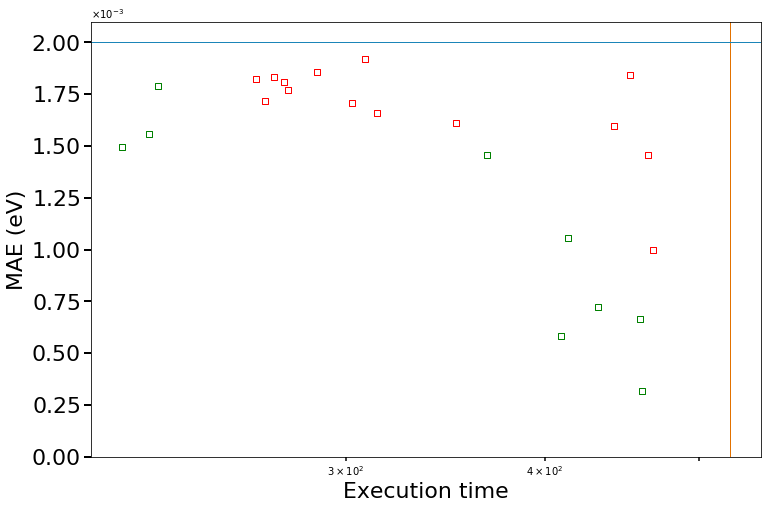

In [158]:
df2 = results['surrogate-all_params']
#df2 =results['SS-500k_allparams']
#df2 = df[df['temperature']==1000]
cases = (
        {'df': df2, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'x'},
    )
magnified(cases)
#plt.ylabel('MAE (eV)')

plt.savefig('Paper_figures/magnified_good.pdf')
plt.show()

## (2) Simple Surrogate Parameter Sweep

/Users/yzamora/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


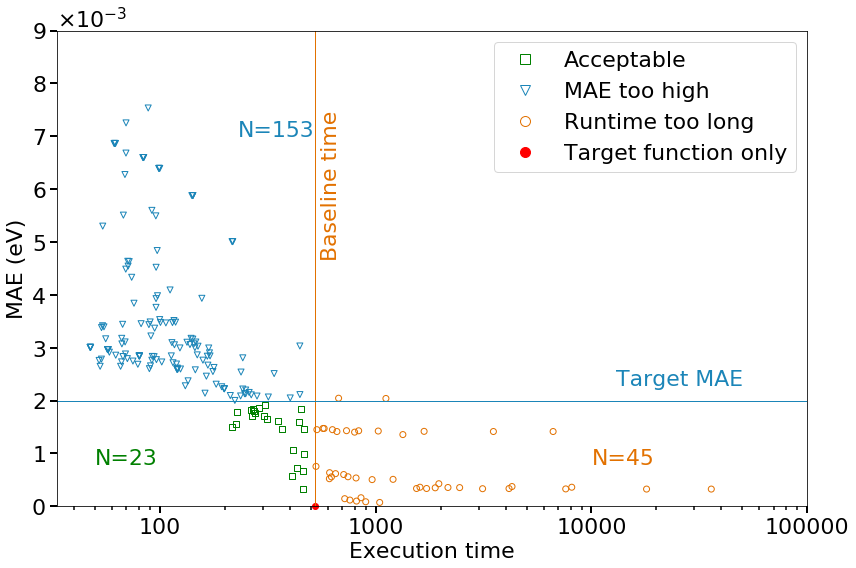

In [82]:
df2 = results['surrogate-all_params']
#df2 =results['SS-500k_allparams']
#df2 = df[df['temperature']==1000]
cases = (
        {'df': df2, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'x'},
    )
_plot_cases_adapted(cases)
plt.ylabel('MAE (eV)')

plt.savefig('Paper_figures/ss_extremeparams.pdf')
plt.show()

## (3) Simple with no retrain interval

### (a) First Method

In [224]:
"""cases = (
        #{'df': results['ss-true-rs1_LAZYTRAIN'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':True},
        {'df': r1, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':True},
    )
_plot_cases_adapted(cases)
plt.ylabel('MAE (eV)')
plt.savefig('Paper_figures/ss_nort.pdf')"""

"cases = (\n        #{'df': results['ss-true-rs1_LAZYTRAIN'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':True},\n        {'df': r1, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':True},\n    )\n_plot_cases_adapted(cases)\nplt.ylabel('MAE (eV)')\nplt.savefig('Paper_figures/ss_nort.pdf')"

### (b) Alternative

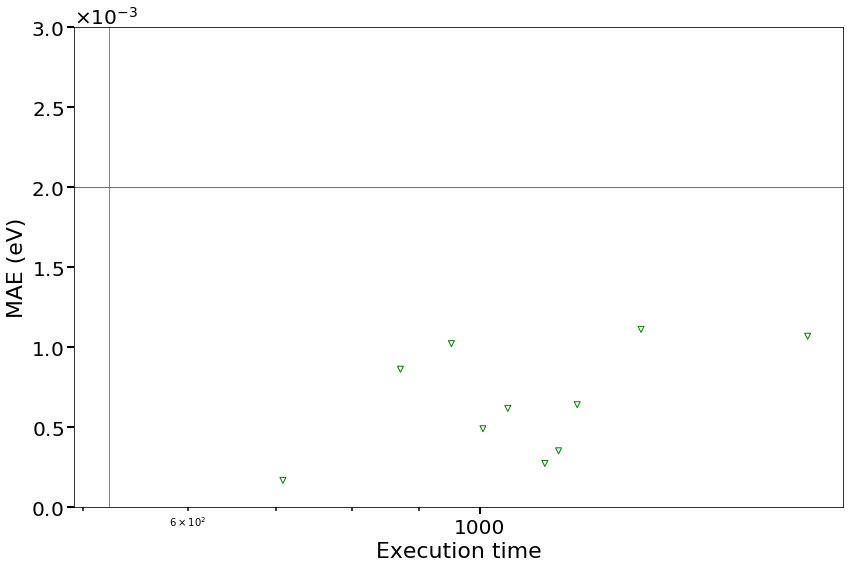

In [161]:
r1 = results['ss-true-rs1_LAZYTRAIN'] 
r1 = r1[r1['interval'] == 1]
cases = (
        #{'df': results['ss-true-rs1_LAZYTRAIN'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
        {'df': r1, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.ylabel('MAE (eV)')
plt.savefig('Paper_figures/ss_nort.pdf')

## Summary results for MAE and Speedup

### (a) Fixed Parameters - 0.3, 50

In [192]:
results_ss = {n: None for n in experiment_ss}
for name in results_ss:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    #mae_values = pa.process_mae(path)
    mae_values = pa.process_noagregg_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results_ss[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

### (b) Proxima - no reference data

In [193]:
results_true = {n: None for n in experiments_true}
for name in results_true:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    #mae_values = pa.process_mae(path)
    mae_values = pa.process_noagregg_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results_true[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

### (c) Combining MAE+Speedup

In [194]:
def summary_speedup(results):
    data_temp = {}
    cols = ["speed_up", "time", "mae"]

    for i,k in results.items():
        data = k.set_index('temperature')
        for t in data.index:

            if t not in data_temp:
                data_temp[t] = defaultdict(list)

            record = data.loc[t]

            for col in cols:
                data_temp[t][col].append(float(record[col]))
    summary = defaultdict(list)
    for i, k in data_temp.items():
        summary["temps"].append(float(i))
        for col in cols:
            summary[col + "_mean"].append(np.mean(k[col]))
            summary[col + "_std"].append(np.std(k[col])/np.sqrt(len(k[col])))

    keys = ["temps"] + [k for k in summary.keys() if k != "temps"]
    result = list(zip(*sorted(zip(*[summary[k] for k in keys]))))
    for i, k in enumerate(keys):
        summary[k] = result[i]
    return summary

In [195]:
summary_no_ref = summary_speedup(results_true)
summary_noref_fixed = summary_speedup(results_ss)

## (d) (4) MAE Results

In [219]:
def mae_results(summary1,summary2):
    RI= True #set true or false depending on retrain interval usage
    SS = False #Comparing with simple surrogate
    temps = np.array(summary1['temps'],dtype='int')
    labels = np.append(temps,'HM').tolist()
    #labels = list(summary1['temps'] + ('HM',))
    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))
    
    #calculating harmonic mean
    hm_prox = stat.harmonic_mean(summary1['mae_mean'])
    hm_fixed = stat.harmonic_mean(summary2['mae_mean'])
    mae_prox = list(summary1['mae_mean'] + (hm_prox,))
    mae_fixed = list(summary2['mae_mean'] + (hm_fixed,))
    
    std_prox_hm = summary1['mae_std'] + (stat.harmonic_mean(summary1['mae_std']),)
    std_fixed_hm = summary2['mae_std']+ (stat.harmonic_mean(summary2['mae_std']),)
    
    rects1 = ax.bar(x - WIDTH/2, mae_prox, WIDTH,yerr=std_prox_hm, label=r'Proxima - No Reference Data')
    rects2 = ax.bar(x + WIDTH/2, mae_fixed, WIDTH, yerr=std_fixed_hm,label='Fixed - No Reference Data')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Energy MAE (eV)', fontsize=BIG)
    ax.set_xlabel("Temperature (K)", fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    ax.plot([-5,10.5],[0.002,0.002],"k--")
    ax.set_xlim([-0.5, 10.5])
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    plt.savefig('Paper_figures/surgOnly_MAE_noref.pdf')

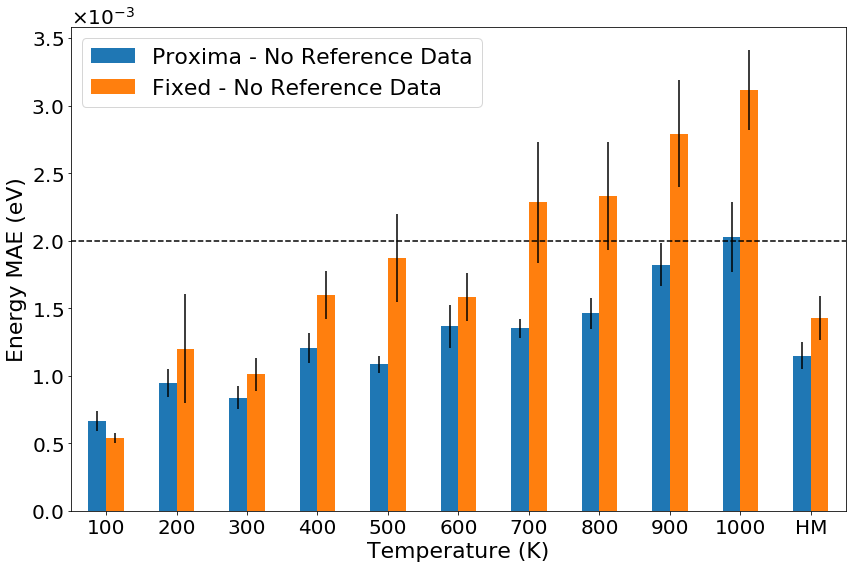

In [220]:
mae_results(summary_no_ref,summary_noref_fixed)

## (e) (5) Speedup

In [203]:
def graph_speedup(_speedup_da, _speedup_sa):
    #labels = list(summary_no_ref['temps'] + ('HM',))
    temps = np.array(summary_no_ref['temps'],dtype='int')
    labels = np.append(temps,'HM').tolist()
    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))
    
    #calculating harmonic mean
    hm_prox = stat.harmonic_mean(_speedup_da['speed_up_mean'])
    hm_fixed = stat.harmonic_mean(_speedup_sa['speed_up_mean'])
    speedup_prox = list(_speedup_da['speed_up_mean'] + (hm_prox,))
    speedup_fixed = list(_speedup_sa['speed_up_mean'] + (hm_fixed,))
    
    std_prox_hm = _speedup_da['speed_up_std'] + (stat.harmonic_mean(_speedup_da['speed_up_std']),)
    std_fixed_hm = _speedup_da['speed_up_std'] + (stat.harmonic_mean(_speedup_sa['speed_up_std']),)
    
    rects1 = ax.bar(x - WIDTH/2, speedup_prox, WIDTH,yerr=std_prox_hm, label='Proxima - No Reference Data')
    rects2 = ax.bar(x + WIDTH/2, speedup_fixed, WIDTH,yerr=std_fixed_hm ,label='Fixed - No Reference Data')

    
    ax.plot([-5,10.5],[1,1],"k--")
    ax.set_xlim([-0.5, 10.5])
    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    plt.savefig('Paper_figures/speedup_noref.pdf')
    plt.show()

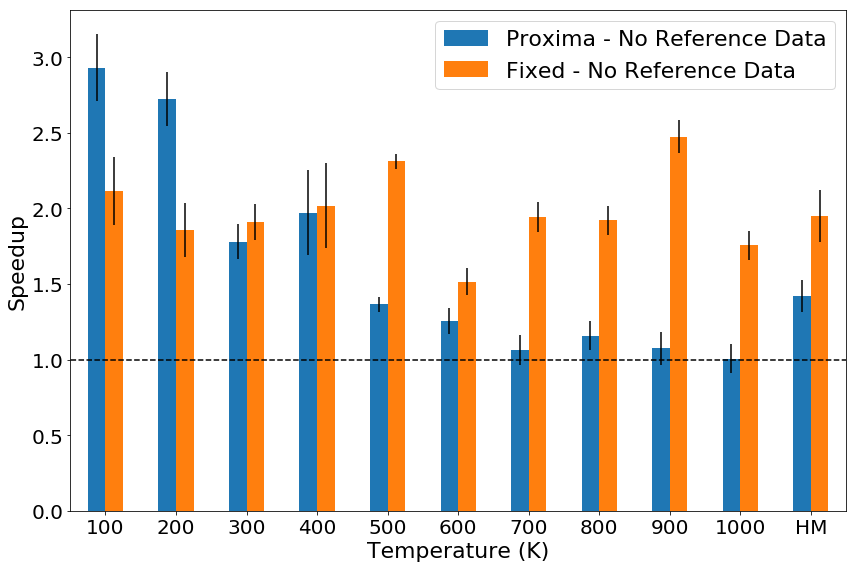

In [204]:
graph_speedup(summary_no_ref,summary_noref_fixed)

## ROG MEAN and MAE

### ROG - Target Function

In [113]:
rog_hf = defaultdict(list)
run_name = 'random-seed_runs/hf_rog'
file = "/".join([root_path, run_name,'result*'])
for f in glob.glob(file):
    control_fn = os.path.basename(f).split('_')
    temp = control_fn[1].split(".json")[0]
    temp = str(int(float(temp)))
    with open(f) as data:
        rog_hf[temp].append(
            json.loads(
                data.read()
            ).get("r_g", None).get("statistic", None)
        )
        
temps = []; rogs_median = []; rogs_std = []
for k, v in rog_hf.items():
    temps.append(float(k))
    rogs_median.append(np.median(v))
    #rogs_median.append(np.mean(v))
    rogs_std.append(np.std(v)/np.sqrt(len(v)-1))

temps, rogs_median, rogs_std = zip(*sorted(zip(temps, rogs_median, rogs_std)))

### ROG - Proxima

In [114]:
rog_dynLns = defaultdict(list)

## True runs - MC simulations not using reference data, running Proxima, lazy training, no surrogate limit
## dynLNS - Proxima, with reference data (lazy training, no surrogate limit)
#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/true-run*'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_dynLns[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_dynLns = []; rogs_dynLns_median = []; rogs_dynLns_std = []
for k, v in rog_dynLns.items():
    temps_dynLns.append(float(k))
    rogs_dynLns_median.append(np.median(v))
    #rogs_dynLns_median.append(np.mean(v))
    rogs_dynLns_std.append(np.std(v)/np.sqrt(len(v)))

temps_dynLns, rogs_dynLns_median, rogs_dynLns_std = zip(
    *sorted(zip(temps_dynLns, rogs_dynLns_median, rogs_dynLns_std))
)

### ROG - Simple Surrogate
Fixed Paramtters - 0.3, 50

In [115]:
rog_SS = defaultdict(list)

## True runs - MC simulations not using reference data, running Proxima, lazy training, no surrogate limit
## dynLNS - Proxima, with reference data (lazy training, no surrogate limit)
#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/ss-true*'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_SS[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_SS = []; rogs_SS_median = []; rogs_SS_std = []
for k, v in rog_SS.items():
    temps_SS.append(float(k))
    #rogs_SS_median.append(np.median(v))
    rogs_SS_median.append(np.mean(v))
    rogs_SS_std.append(np.std(v)/np.sqrt(len(v)))

temps_SS, rogs_SS_median, rogs_SS_std = zip(
    *sorted(zip(temps_SS, rogs_SS_median, rogs_SS_std))
)

In [117]:
def ROG_mae_results(summary1,summary2):
    RI= True #set true or false depending on retrain interval usage
    SS = False #Comparing with simple surrogate

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,8))

    rects1 = ax.bar(x - WIDTH/2, list(summary1['mae_mean']), WIDTH,label=r'Proxima - No Reference Data')
    rects2 = ax.bar(x + WIDTH/2, list(summary2['mae_mean']), WIDTH,label='Fixed - No Reference Data')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean absolute error', fontsize=BIG)
    ax.set_xlabel("Temperature (K)", fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    #plt.savefig('Figures/3prox_MAEbar.pdf')

In [118]:
#rog_summary = pd.DataFrame(k for k in rog_hf.keys() if k != "list")
rog_summary = pd.DataFrame({'Temperature': [k for k in rog_hf.keys()]})
for name, d in [('Dynamic',rog_dynLns), ('Target',rog_hf), ('Fixed',rog_SS)]:
    col_m = []; col_s = []
    
    for T in rog_summary['Temperature']:
        col_m.append(np.mean(d[T]))
        col_s.append(np.std(d[T])/np.sqrt(len(d[T])))
    #import pdb; pdb.set_trace()
    rog_summary[f"{name}_mean"] = col_m
    rog_summary[f"{name}_stderr"] = col_s

In [119]:
rog_summary['T'] = rog_summary['Temperature'].astype('int')
rog_summary = rog_summary.sort_values('T')

## (6) ROG MEAN

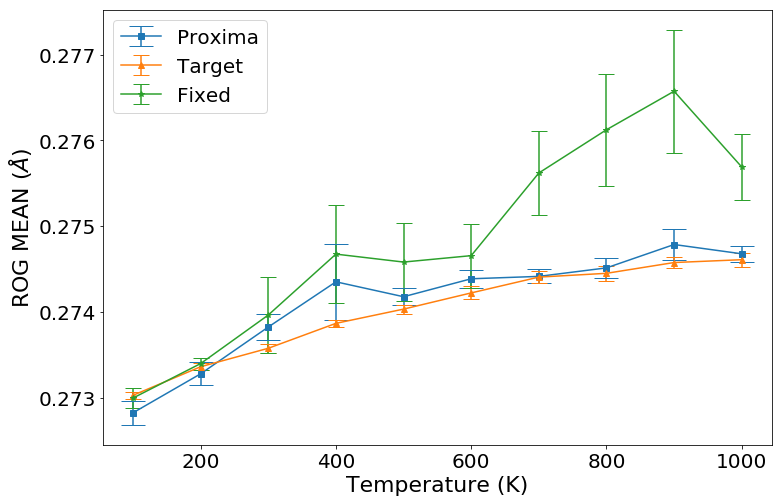

In [120]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,8))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)

ax.errorbar(rog_summary['T'],rog_summary['Dynamic_mean'],yerr=rog_summary['Dynamic_stderr'],label='Proxima', capsize=12.0, fmt="s-")
ax.errorbar(rog_summary['T'],rog_summary['Target_mean'],yerr=rog_summary['Target_stderr'],label='Target', capsize=8.0, fmt="^-")
ax.errorbar(rog_summary['T'],rog_summary['Fixed_mean'],yerr=rog_summary['Fixed_stderr'], label='Fixed',capsize=8.0, fmt="*-")

"""ax.errorbar(rog_summary['T'],rog_summary['Dynamic_mean'],label='Dynamic', capsize=12.0, fmt="s-")
ax.errorbar(rog_summary['T'],rog_summary['Target_mean'],label='Target', capsize=8.0, fmt="^-")
ax.errorbar(rog_summary['T'],rog_summary['Fixed_mean'], label='Fixed',capsize=8.0, fmt="*-")"""
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend(fontsize=MEDIUM)
plt.xlabel('Temperature (K)')
plt.ylabel('ROG MEAN ($\AA$)')
plt.savefig('Paper_figures/mean_ROG.pdf')

## (7) ROG MAE

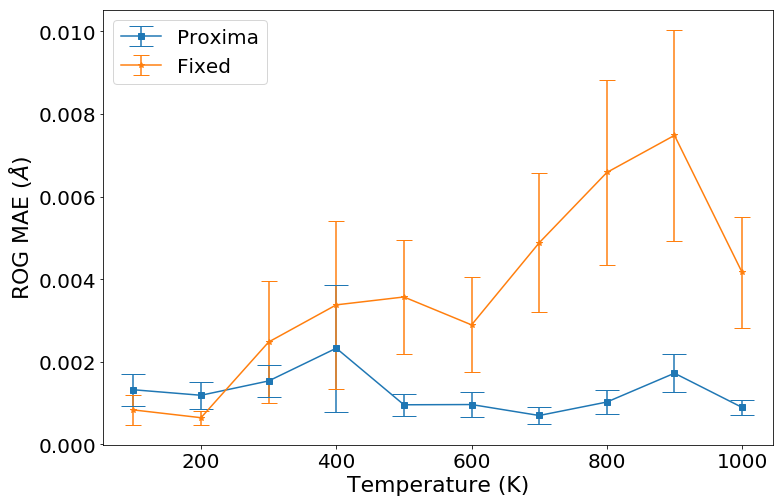

In [76]:
#rog_summary = pd.DataFrame(k for k in rog_hf.keys() if k != "list")
rog_summary = pd.DataFrame({'Temperature': [k for k in rog_hf.keys()]})

for name, d in [('Target',rog_hf)]:
    col_m = []; col_s = []
    
    for T in rog_summary['Temperature']:
        col_m.append(np.mean(d[T]))
        col_s.append(np.std(d[T])/np.sqrt(len(d[T])))
    #import pdb; pdb.set_trace()
    rog_summary[f"{name}_mean"] = col_m
    #rog_summary[f"{name}_stderr"] = col_s

rog_summary["T"] = rog_summary['Temperature']
rog_summary = rog_summary.set_index("T") 
for name, d in [('Dynamic',rog_dynLns), ('Fixed',rog_SS)]:
    col_m = []; col_s = []
    for T in rog_summary['Temperature']:
        
        #import pdb; pdb.set_trace()
        size = len(d[T])
        dT = np.array(d[T])
        ref = np.array([rog_summary["Target_mean"].loc[T]] * size)
        
        ae = abs(dT - ref) / ref
        
        col_m.append(np.mean(ae))
        col_s.append(np.std(ae)/np.sqrt(size))
    #import pdb; pdb.set_trace()
    rog_summary[f"{name}_mae"] = col_m
    rog_summary[f"{name}_stderr"] = col_s
    
rog_summary.reset_index(drop=False,inplace=True)
rog_summary['T'] = rog_summary['Temperature'].astype('int')
rog_summary = rog_summary.sort_values('T')

fig, ax = plt.subplots(figsize=(FIGWIDTH,8))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.errorbar(rog_summary['T'],rog_summary['Dynamic_mae'],yerr=rog_summary['Dynamic_stderr'],label='Proxima', capsize=12.0, fmt="s-")
#ax.errorbar(rog_summary['T'],rog_summary['Target_mae'],yerr=rog_summary['Target_stderr'],label='Target', capsize=8.0, fmt="^-")
ax.errorbar(rog_summary['T'],rog_summary['Fixed_mae'],yerr=rog_summary['Fixed_stderr'], label='Fixed',capsize=8.0, fmt="*-")
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend(fontsize=MEDIUM)
plt.xlabel('Temperature (K)')
plt.ylabel('ROG MAE ($\AA$)')
plt.savefig('Paper_figures/MAE_ROG.pdf')

## (8) UQ Threshold Sweep 

In [77]:
## Data
thresholds = [0.0005,0.001,0.002,0.004,0.006]
mae_vals = [0.000066,0.000576,0.001550,0.002577,0.002267]
times = [6171,666.8018,279.8098,116.0945,95.8729]
hf_time = 530 #average time


nom_error = [m/t for m,t in zip(mae_vals,thresholds)]
speedup = [hf_time/x for x in times]


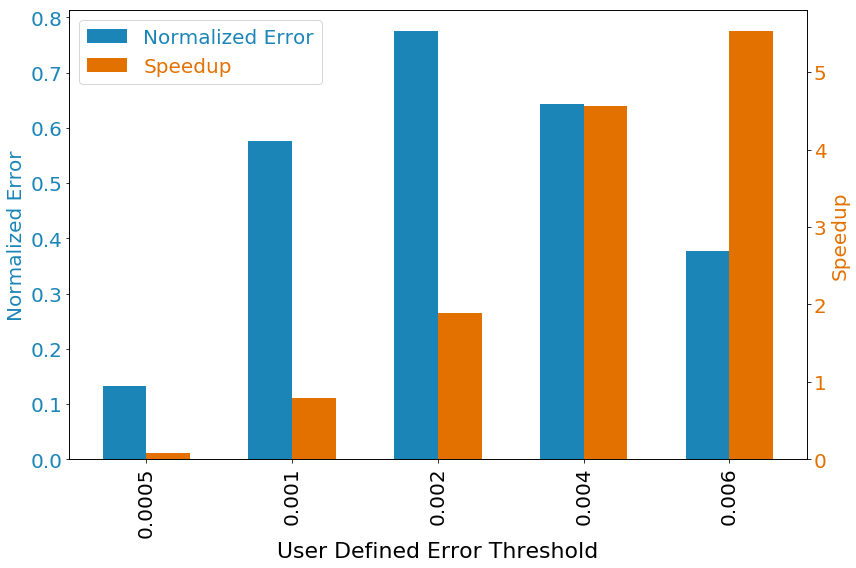

In [78]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,8))

SPEEDUP_COLOR = colors[0]
NORMERROR_COLOR = colors[1]
SPEEDUP_LABEL = 'Speedup'
NORMERROR_LABEL = 'Normalized Error'

thres = ['0.0005', '0.001', '0.002', '0.004', '0.006']
labels = list(thres)
ax1 = plt.subplot(1,1,1)
w = 0.3
x = np.arange(len(labels))
plt.xticks(x+w/2, labels, rotation='vertical',fontsize=MEDIUM)

ax.set_xticklabels(labels,Fontsize=MEDIUM)
pop =ax1.bar(x, nom_error, width=w, color=NORMERROR_COLOR, align='center')
plt.ylabel('Normalized Error',fontsize=MEDIUM, color=NORMERROR_COLOR)
plt.yticks(fontsize=MEDIUM, color=NORMERROR_COLOR)

ax2 = ax1.twinx()
gdp =ax2.bar(x+w, speedup, width=w,color=SPEEDUP_COLOR,align='center')
plt.ylabel('Speedup',fontsize=MEDIUM, color=SPEEDUP_COLOR)
plt.yticks(fontsize=MEDIUM, color=SPEEDUP_COLOR)


legend = plt.legend([pop, gdp],['Normalized Error', 'Speedup'],fontsize=MEDIUM) # loc='upper left')
texts = legend.get_texts()
plt.setp(texts[0], color=NORMERROR_COLOR)
plt.setp(texts[1], color=SPEEDUP_COLOR)
#ax2.set_xlabel('User Designed Error Threshold', fontsize=BIG);
#plt.xlabel('User Designed Error Threshold', fontsize=BIG);
ax1.set_xlabel('User Defined Error Threshold', fontsize=BIG);

plt.tight_layout()
plt.savefig('Paper_figures/uqthresh_normerror_speedup.pdf')

plt.show()